# Multilevel Gravity Survey with MLDA

### The MLDA sampler
This notebook is designed to demonstrate the Multi-Level Delayed Acceptance MCMC algorithm (MLDA) proposed in Dodwell (2019), as implemented within PyMC3. If you are using MLDA for the first time, we recommend first running the `MLDA_simple_linear_regression.ipynb` notebook in the same folder.

The MLDA sampler can be more efficient than other MCMC samplers when dealing with computationally intensive problems where we have access not only to the desired (fine) posterior distribution but also to a set of approximate (coarse) posteriors of decreasing accuracy and decreasing computational cost. In simple terms, we can use multiple chains on different coarseness levels and coarser chains' samples are used as proposals for the finer chains. This has been shown to improve the effective sample size of the finest chain and this allows us to reduce the number of expensive fine-chain likelihood evaluations. 

The notebook initially defines the necessary classes that describe the model. These classes use scipy to do the numerical solve in the forward model. It then instantiates models in two levels (with different granularities) and generates data for inference. Finally, the model classes are passed to two pymc3 models using Theano Ops and inference is done using three different MCMC methods (including MLDA). Some summary results and comparison plots are shown at the end to demonstrate the results. The use of Theano Ops is common when users want to use external code to calculate their likelihood (e.g. some fast PDE solver) and this example is designed to serve as a starting point for users to employ MLDA in their own problems.

Please note that the MLDA sampler is new in PyMC3. The user should be extra critical about the results and report any problems as issues in the pymc3's github repository.

The notebook results shown below were generated on a MacBook Pro with a 2.6 GHz 6-core Intel Core i7, 32 GB DDR4 and macOS 10.15.4.

### Gravity Surveying
In this notebook, we solve a 2-dimensional gravity surveying problem, adapted from the 1D problem presented in Hansen (2010). 

Our aim is to recover a two-dimensional mass distribution $f(\vec{t})$ at a known depth $d$ below the surface from measurements $g(\vec{s})$ of the vertical component of the gravitational field at the surface. The contribution to $g(\vec{s})$ from infinitesimally small areas of the subsurface mass distribution are given by:

\begin{equation}
    dg = \frac{\sin \theta}{r^2} f(\vec{t}) \: d\vec{t}
\end{equation}
where $\theta$ is the angle between the vertical plane and a straight line between two points $f(\vec{t})$ and $g(\vec{s})$, and $r = | \vec{s} - \vec{t} |$ is the Eucledian distance between the points. We exploit that $\sin \theta = \frac{d}{r}$, so that

\begin{equation}
    \frac{\sin \theta}{r^2} f(\vec{t}) \: d\vec{t} = \frac{d}{r^3} f(\vec{t}) \: d\vec{t} = \frac{d}{ | \vec{s} - \vec{t} |^3} f(\vec{t}) \: d\vec{t}
\end{equation}

This yields the integral equation,

\begin{equation}
    g(\vec{s}) = \iint_T \frac{d}{ | \vec{s} - \vec{t} |^3} f(\vec{t}) \: d\vec{t}
\end{equation}

where $T = [0,1]^2$ is the domain of the function $f(\vec{t})$. This constitutes our forward model.

We solve this integral numerically using midpoint quadrature. For simplicity, we use the same number of quadrature points along each axis, so that in discrete form our forward model becomes

\begin{equation}
    g(\vec{s}_i) = \sum_{j=1}^{m} \omega_j \frac{d}{ | \vec{s}_i - \vec{t}_j |^3} \hat{f}(\vec{t}_j), \quad i = 1, \dots, n, \quad j = 1, \dots, m
\end{equation}

where $\omega_j = \frac{1}{m}$ are quadrature weights, $\hat{f}(\vec{t}_j)$ is the approximate subsurface mass at quadrature points $j = 1, \dots, m$, and  $g(\vec{s}_i)$ is surface measurements at collocation points $i = 1, \dots, n$. Hence when $n > m$, we are dealing with an overdetermined problem and vice versa. 

This results in a linear system $\mathbf{Ax = b}$, where
\begin{equation}
    a_{ij} = \omega_j \frac{d}{ | \vec{s}_i - \vec{t}_j |^3}, \quad x_j = \hat{f}(\vec{t}_j), \quad b_i = g(\vec{s}_i).
\end{equation}
In this particular problem, the matrix $\mathbf{A}$ has a very high condition number, leading to an ill-posed inverse problem, which entails numerical instability and spurious, often oscillatory, solutions for noisy right hand sides. These types of problems are traditionally solved by way of some manner of *regularisation*, but they can be handled in a natural and elegant fashion in the context of a Bayesian inverse problem.

### Mass Distribution as a Gaussian Random Process
We model the unknown mass distribution as a Gaussian Random Process with a Matern 5/2 covariance kernel (Rasmussen and Williams, 2006):
\begin{equation}
    C_{5/2}(\vec{t}, \vec{t}') = \sigma^2 \left( 1 + \frac{\sqrt{5} | \vec{t}-\vec{t}' | }{l} + \frac{5 | \vec{t}-\vec{t}' |^2}{3l^2} \right) \exp \left( - \frac{\sqrt{5} | \vec{t}-\vec{t}' | }{l} \right)
\end{equation}
where $l$ is the covariance length scale and $\sigma^2$ is the variance.

### Comparison
Within this notebook, a simple MLDA sampler is compared to a Metropolis and a DEMetropolisZ sampler. The example demonstrates that MLDA is more efficient than the other samplers when measured by the Effective Samples per Second they can generate from the posterior. 

### References

Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X

Per Christian Hansen. *Discrete Inverse Problems: Insight and Algorithms*. Society for Industrial and Applied Mathematics, January 2010.

Carl Edward Rasmussen and Christopher K. I. Williams. *Gaussian processes for machine learning*. Adaptive computation and machine learning. 2006.

## Import modules

In [1]:
import os as os
import warnings

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable

import sys as sys
import time as time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as tt

from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.linalg import eigh
from scipy.spatial import distance_matrix

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
RANDOM_SEED = 123446
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# Checking versions
print(f"Theano version: {theano.__version__}")
print(f"PyMC3 version: {pm.__version__}")

Theano version: 1.1.2
PyMC3 version: 3.11.0


## Define Matern52 kernel for modelling Gaussian Random Field
This is utility code which is necessary for defining the model later - you are free to ignore it or place it in an external file

In [5]:
class SquaredExponential:
    def __init__(self, coords, mkl, lamb):
        """
        This class sets up a random process
        on a grid and generates
        a realisation of the process, given
        parameters or a random vector.
        """

        # Internalise the grid and set number of vertices.
        self.coords = coords
        self.n_points = self.coords.shape[0]
        self.eigenvalues = None
        self.eigenvectors = None
        self.parameters = None
        self.random_field = None

        # Set some random field parameters.
        self.mkl = mkl
        self.lamb = lamb

        self.assemble_covariance_matrix()

    def assemble_covariance_matrix(self):
        """
        Create a snazzy distance-matrix for rapid
        computation of the covariance matrix.
        """
        dist = distance_matrix(self.coords, self.coords)

        # Compute the covariance between all
        # points in the space.
        self.cov = np.exp(-0.5 * dist**2 / self.lamb**2)

    def plot_covariance_matrix(self):
        """
        Plot the covariance matrix.
        """
        plt.figure(figsize=(10, 8))
        plt.imshow(self.cov, cmap="binary")
        plt.colorbar()
        plt.show()

    def compute_eigenpairs(self):
        """
        Find eigenvalues and eigenvectors using Arnoldi iteration.
        """
        eigvals, eigvecs = eigh(self.cov, eigvals=(self.n_points - self.mkl, self.n_points - 1))

        order = np.flip(np.argsort(eigvals))
        self.eigenvalues = eigvals[order]
        self.eigenvectors = eigvecs[:, order]

    def generate(self, parameters=None):
        """
        Generate a random field, see
        Scarth, C., Adhikari, S., Cabral, P. H.,
        Silva, G. H. C., & Prado, A. P. do. (2019).
        Random field simulation over curved surfaces:
        Applications to computational structural mechanics.
        Computer Methods in Applied Mechanics and Engineering,
        345, 283–301. https://doi.org/10.1016/j.cma.2018.10.026
        """

        if parameters is None:
            self.parameters = np.random.normal(size=self.mkl)
        else:
            self.parameters = np.array(parameters).flatten()

        self.random_field = np.linalg.multi_dot(
            (self.eigenvectors, np.sqrt(np.diag(self.eigenvalues)), self.parameters)
        )

    def plot(self, lognormal=True):
        """
        Plot the random field.
        """

        if lognormal:
            random_field = self.random_field
            contour_levels = np.linspace(min(random_field), max(random_field), 20)
        else:
            random_field = np.exp(self.random_field)
            contour_levels = np.linspace(min(random_field), max(random_field), 20)

        plt.figure(figsize=(12, 10))
        plt.tricontourf(
            self.coords[:, 0],
            self.coords[:, 1],
            random_field,
            levels=contour_levels,
            cmap="plasma",
        )
        plt.colorbar()
        plt.show()


class Matern52(SquaredExponential):
    def assemble_covariance_matrix(self):
        """
        This class inherits from RandomProcess and creates a Matern 5/2 covariance matrix.
        """

        # Compute scaled distances.
        dist = np.sqrt(5) * distance_matrix(self.coords, self.coords) / self.lamb

        # Set up Matern 5/2 covariance matrix.
        self.cov = (1 + dist + dist**2 / 3) * np.exp(-dist)

## Define the Gravity model and generate data
This is a bit lengthy due to the model used in this case, it contains class definitions and also instantiation of class objects and data generation.

In [6]:
# Set the model parameters.
depth = 0.1
n_quad = 64
n_data = 64

# noise level
noise_level = 0.02

# Set random process parameters.
lamb = 0.1
mkl = 14

# Set the quadrature degree for each model level (coarsest first)
n_quadrature = [16, 64]

In [7]:
class Gravity:
    """
    Gravity is a class that implements a simple gravity surveying problem,
    as described in Hansen, P. C. (2010). Discrete Inverse Problems: Insight and Algorithms.
    Society for Industrial and Applied Mathematics.
    It uses midpoint quadrature to evaluate a Fredholm integral of the first kind.
    """

    def __init__(self, f_function, depth, n_quad, n_data):
        # Set the function describing the distribution of subsurface density.
        self.f_function = f_function

        # Set the depth of the density (distance to the surface measurements).
        self.depth = depth

        # Set the quadrature degree along one dimension.
        self.n_quad = n_quad

        # Set the number of data points along one dimension
        self.n_data = n_data

        # Set the quadrature points.
        x = np.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = np.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = np.meshgrid(self.tx, self.ty)

        # Set the measurement points.
        self.sx = np.linspace(0, 1, self.n_data)
        self.sy = np.linspace(0, 1, self.n_data)
        SX, SY = np.meshgrid(self.sx, self.sy)

        # Create coordinate vectors.
        self.T_coords = np.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad**2)]
        self.S_coords = np.c_[SX.ravel(), SY.ravel(), self.depth * np.ones(self.n_data**2)]

        # Set the quadrature weights.
        self.w = 1 / self.n_quad**2

        # Compute a distance matrix
        dist = distance_matrix(self.S_coords, self.T_coords)

        # Create the Fremholm kernel.
        self.K = self.w * self.depth / dist**3

        # Evaluate the density function on the quadrature points.
        self.f = self.f_function(TX, TY).flatten()

        # Compute the surface density (noiseless measurements)
        self.g = np.dot(self.K, self.f)

    def plot_model(self):
        # Plot the density and the signal.
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes[0].set_title("Density")
        f = axes[0].imshow(
            self.f.reshape(self.n_quad, self.n_quad),
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="plasma",
        )
        fig.colorbar(f, ax=axes[0])
        axes[1].set_title("Signal")
        g = axes[1].imshow(
            self.g.reshape(self.n_data, self.n_data),
            extent=(0, 1, 0, 1),
            origin="lower",
            cmap="plasma",
        )
        fig.colorbar(g, ax=axes[1])
        plt.show()

    def plot_kernel(self):
        # Plot the kernel.
        plt.figure(figsize=(8, 6))
        plt.imshow(self.K, cmap="plasma")
        plt.colorbar()
        plt.show()

In [8]:
# This is a function describing the subsurface density.
def f(TX, TY):
    f = np.sin(np.pi * TX) + np.sin(3 * np.pi * TY) + TY + 1
    f = f / f.max()
    return f

In [9]:
# Initialise a model
model_true = Gravity(f, depth, n_quad, n_data)

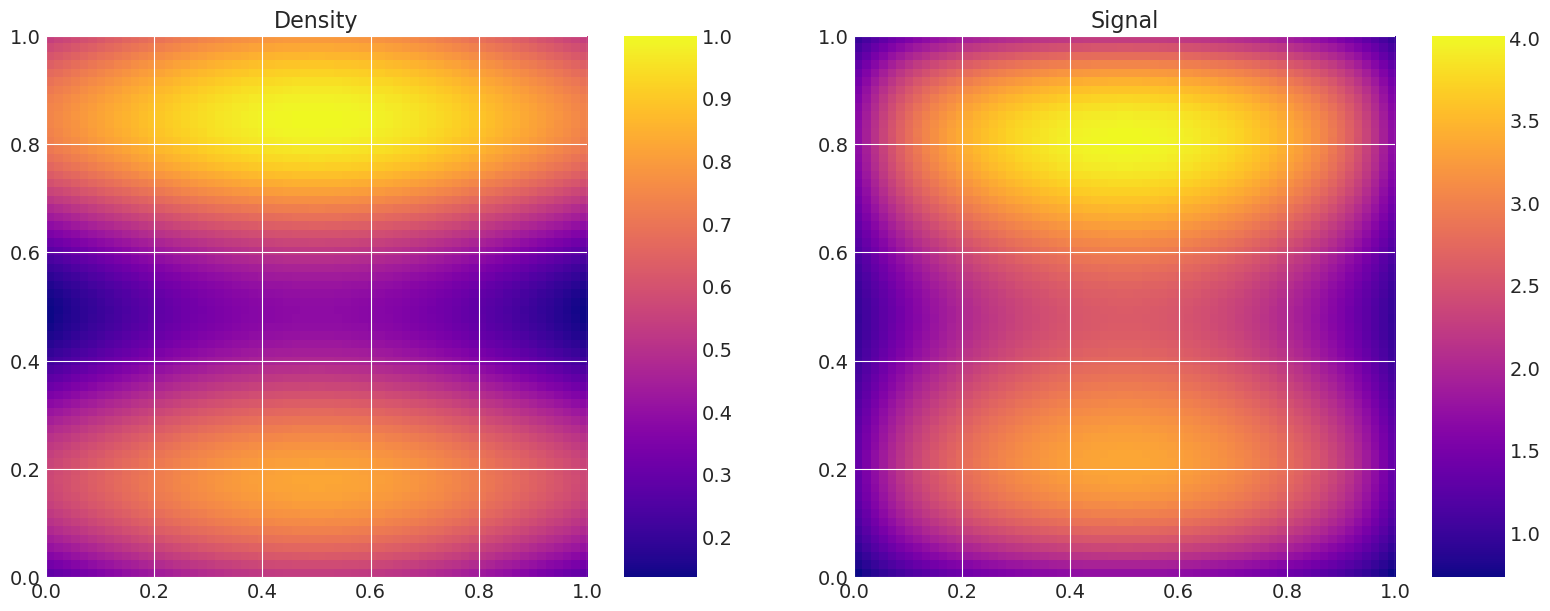

In [10]:
model_true.plot_model()

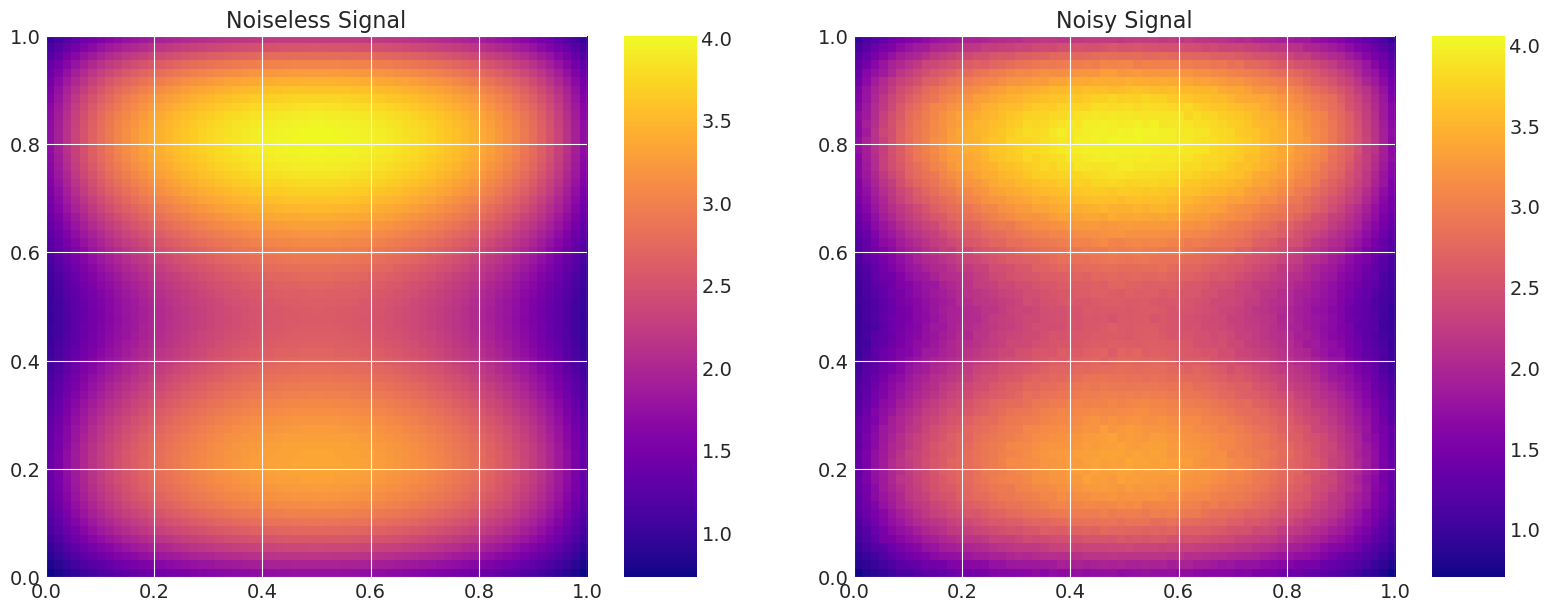

In [11]:
# Add noise to the data.
np.random.seed(123)
noise = np.random.normal(0, noise_level, n_data**2)
data = model_true.g + noise

# Plot the density and the signal.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].set_title("Noiseless Signal")
g = axes[0].imshow(
    model_true.g.reshape(n_data, n_data),
    extent=(0, 1, 0, 1),
    origin="lower",
    cmap="plasma",
)
fig.colorbar(g, ax=axes[0])
axes[1].set_title("Noisy Signal")
d = axes[1].imshow(data.reshape(n_data, n_data), extent=(0, 1, 0, 1), origin="lower", cmap="plasma")
fig.colorbar(d, ax=axes[1])
plt.show()

In [12]:
class Gravity_Forward(Gravity):
    """
    Gravity forward is a class that implements the gravity problem,
    but computation of signal and density is delayed to the "solve"
    method, since it relied on a Gaussian Random Field to model
    the (unknown) density.
    """

    def __init__(self, depth, n_quad, n_data):
        # Set the depth of the density (distance to the surface measurements).
        self.depth = depth

        # Set the quadrature degree along one axis.
        self.n_quad = n_quad

        # Set the number of data points along one axis.
        self.n_data = n_data

        # Set the quadrature points.
        x = np.linspace(0, 1, self.n_quad + 1)
        self.tx = (x[1:] + x[:-1]) / 2
        y = np.linspace(0, 1, self.n_quad + 1)
        self.ty = (y[1:] + y[:-1]) / 2
        TX, TY = np.meshgrid(self.tx, self.ty)

        # Set the measurement points.
        self.sx = np.linspace(0, 1, self.n_data)
        self.sy = np.linspace(0, 1, self.n_data)
        SX, SY = np.meshgrid(self.sx, self.sy)

        # Create coordinate vectors.
        self.T_coords = np.c_[TX.ravel(), TY.ravel(), np.zeros(self.n_quad**2)]
        self.S_coords = np.c_[SX.ravel(), SY.ravel(), self.depth * np.ones(self.n_data**2)]

        # Set the quadrature weights.
        self.w = 1 / self.n_quad**2

        # Compute a distance matrix
        dist = distance_matrix(self.S_coords, self.T_coords)

        # Create the Fremholm kernel.
        self.K = self.w * self.depth / dist**3

    def set_random_process(self, random_process, lamb, mkl):
        # Set the number of KL modes.
        self.mkl = mkl

        # Initialise a random process on the quadrature points.
        # and compute the eigenpairs of the covariance matrix,
        self.random_process = random_process(self.T_coords, self.mkl, lamb)
        self.random_process.compute_eigenpairs()

    def solve(self, parameters):
        # Internalise the Random Field parameters
        self.parameters = parameters

        # Create a realisation of the random process, given the parameters.
        self.random_process.generate(self.parameters)
        mean = 0.0
        stdev = 1.0

        # Set the density.
        self.f = mean + stdev * self.random_process.random_field

        # Compute the signal.
        self.g = np.dot(self.K, self.f)

    def get_data(self):
        # Get the data vector.
        return self.g

In [13]:
# We project the eigenmodes of the fine model to the quadrature points
# of the coarse model using linear interpolation.
def project_eigenmodes(model_coarse, model_fine):
    model_coarse.random_process.eigenvalues = model_fine.random_process.eigenvalues
    for i in range(model_coarse.mkl):
        interpolator = RectBivariateSpline(
            model_fine.tx,
            model_fine.ty,
            model_fine.random_process.eigenvectors[:, i].reshape(
                model_fine.n_quad, model_fine.n_quad
            ),
        )
        model_coarse.random_process.eigenvectors[:, i] = interpolator(
            model_coarse.tx, model_coarse.ty
        ).ravel()

In [14]:
# Initialise the models, according the quadrature degree.
my_models = []
for i, n_quad in enumerate(n_quadrature):
    my_models.append(Gravity_Forward(depth, n_quad, n_data))
    my_models[i].set_random_process(Matern52, lamb, mkl)

# Project the eigenmodes of the fine model to the coarse model.
for m in my_models[:-1]:
    project_eigenmodes(m, my_models[-1])

## Solve and plot models to demonstrate coarse/fine difference

Level 0:


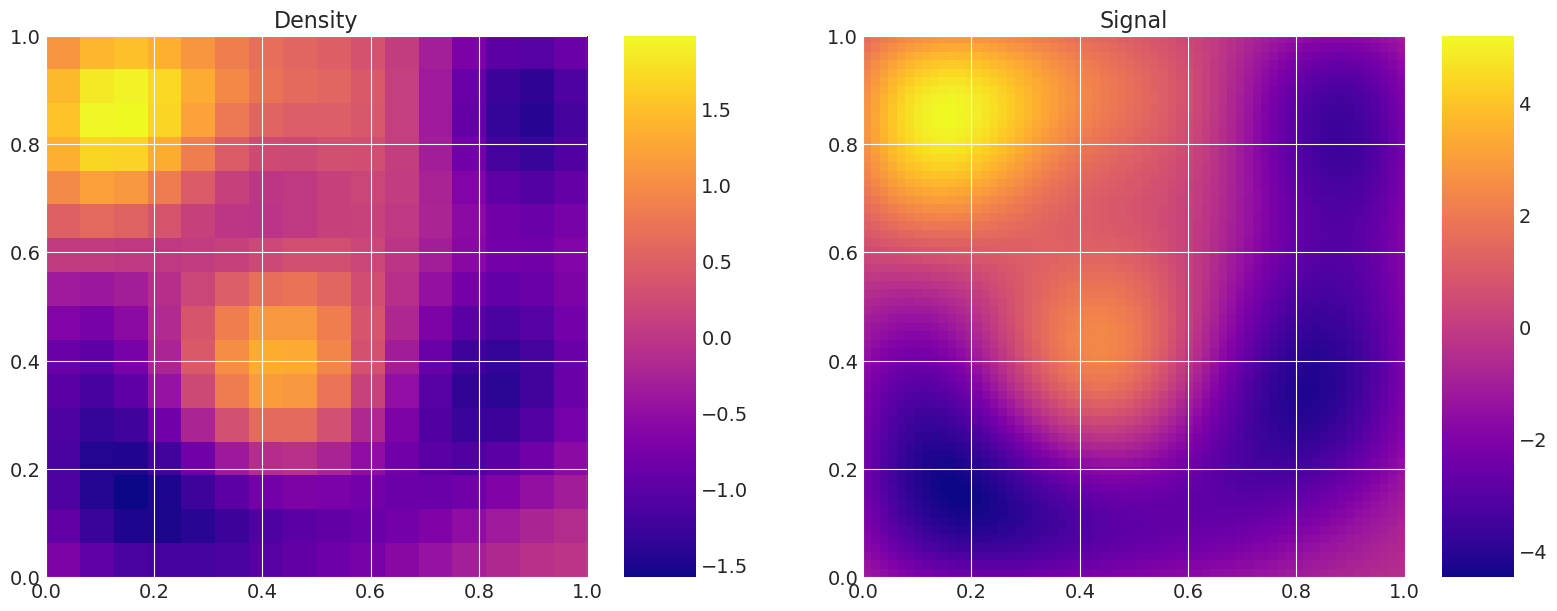

Level 1:


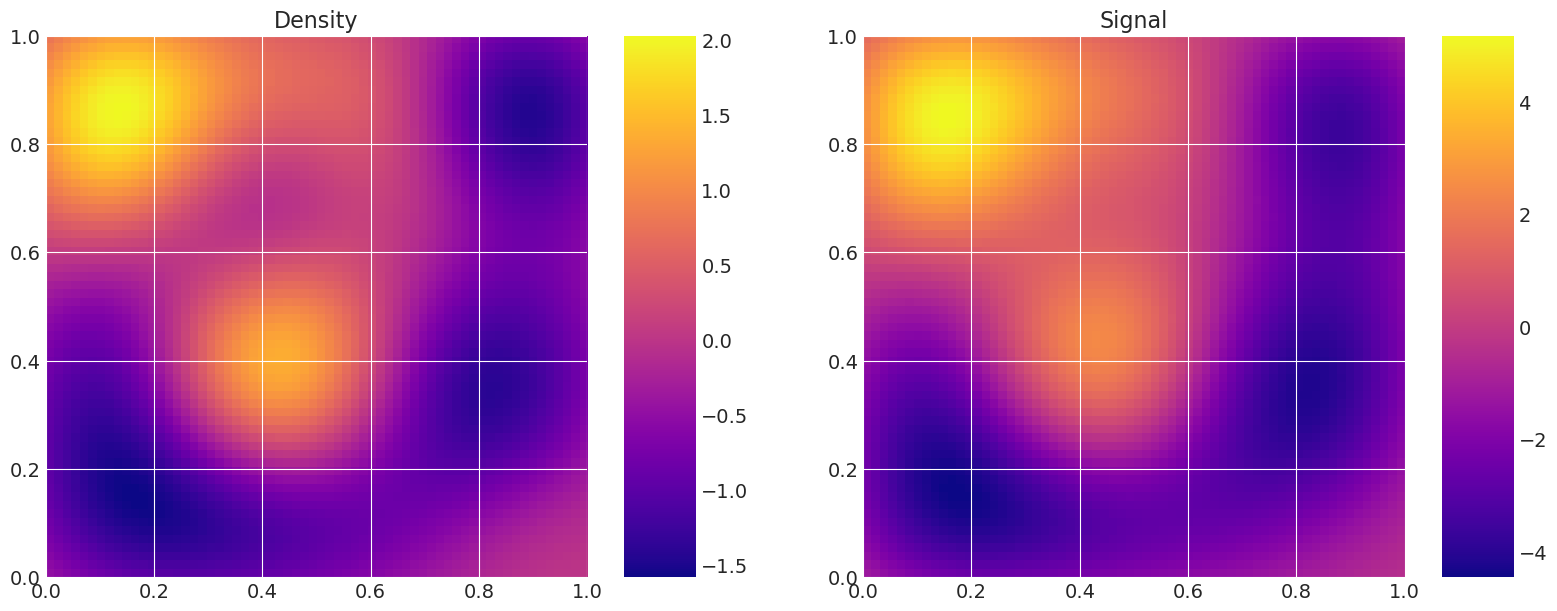

In [15]:
# Plot the same random realisation for each level, and the corresponding signal,
# to validate that the levels are equivalents.
for i, m in enumerate(my_models):
    print(f"Level {i}:")
    np.random.seed(2)
    m.solve(np.random.normal(size=mkl))
    m.plot_model()

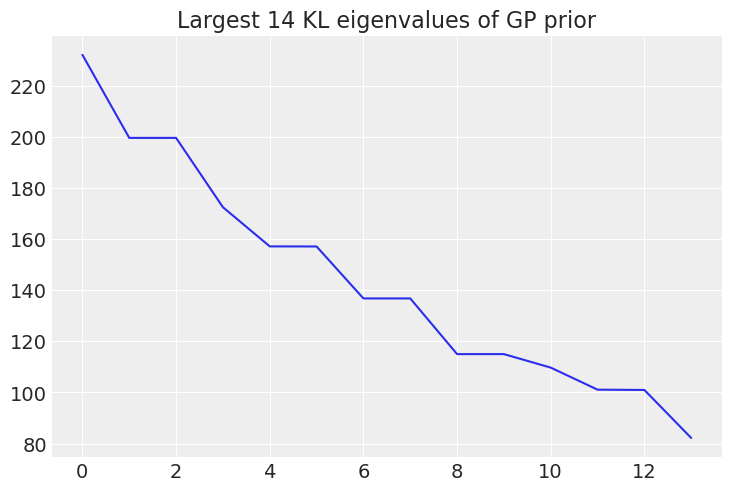

In [16]:
plt.title(f"Largest {mkl} KL eigenvalues of GP prior")
plt.plot(my_models[-1].random_process.eigenvalues)
plt.show()

## Compare computation cost of coarse and fine model solve
The bigger the difference in time, the more MLDA has potential to increase efficiency

In [17]:
%%timeit
my_models[0].solve(np.random.normal(size=mkl))

259 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit
my_models[-1].solve(np.random.normal(size=mkl))

5.4 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Set MCMC parameters for inference

In [19]:
# Number of draws from the distribution
ndraws = 15000

# Number of burn-in samples
nburn = 10000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Number of independent chains.
nchains = 3

# Subsampling rate for MLDA
nsub = 5

# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.zeros(mkl)
cov_prior = np.eye(mkl)

# Set the sigma for inference.
sigma = 1.0

# Sampling seed
sampling_seed = RANDOM_SEED

## Define a Theano Op for the likelihood
This creates the theano op needed to pass the above model to the PyMC3 sampler

In [20]:
def my_loglik(my_model, theta, data, sigma):
    """
    This returns the log-likelihood of my_model given theta,
    datapoints, the observed data and sigma. It uses the
    model_wrapper function to do a model solve.
    """
    my_model.solve(theta)
    output = my_model.get_data()
    return -(0.5 / sigma**2) * np.sum((output - data) ** 2)


class LogLike(tt.Op):
    """
    Theano Op that wraps the log-likelihood computation, necessary to
    pass "black-box" code into pymc3.
    Based on the work in:
    https://docs.pymc.io/notebooks/blackbox_external_likelihood.html
    https://docs.pymc.io/Advanced_usage_of_Theano_in_PyMC3.html
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model and a model object) and returning a single "scalar"
    # value (the log-likelihood)
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        my_model:
            A Model object (defined in model.py) that contains the parameters
            and functions of out model.
        loglike:
            The log-likelihood function we've defined, in this example it is
            my_loglik.
        data:
            The "observed" data that our log-likelihood function takes in. These
            are the true data generated by the finest model in this example.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        sigma:
            The noise standard deviation that our function requires.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.likelihood = loglike
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(self.my_model, theta, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

In [21]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logl = []
for i, m_i in enumerate(my_models):
    logl.append(LogLike(m_i, my_loglik, data, sigma))

## Create coarse model in PyMC3

In [22]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # Multivariate normal prior.
        theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=mkl)

        # Use the Potential class to evaluate likelihood
        pm.Potential("likelihood", logl[j](theta))

    coarse_models.append(model)

## Create fine model and perform inference
Note that we sample using all three methods and that we use the MAP as the starting point for sampling

In [23]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []

with pm.Model() as model:
    # Multivariate normal prior.
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=mkl)

    # Use the Potential class to evaluate likelihood
    pm.Potential("likelihood", logl[-1](theta))

    # Find the MAP estimate which is used as the starting point for sampling
    MAP = pm.find_MAP()

    # Initialise a Metropolis, DEMetropolisZ and MLDA step method objects (passing the subsampling rate and
    # coarse models list for the latter)
    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)
    step_demetropolisz = pm.DEMetropolisZ(tune_interval=tune_interval)
    step_mlda = pm.MLDA(
        coarse_models=coarse_models, subsampling_rates=nsub, base_tune_interval=tune_interval
    )

    # Inference!
    # Metropolis
    t_start = time.time()
    method_names.append("Metropolis")
    traces.append(
        pm.sample(
            draws=ndraws,
            step=step_metropolis,
            chains=nchains,
            tune=nburn,
            discard_tuned_samples=discard_tuning,
            random_seed=sampling_seed,
            start=MAP,
            cores=1,
            mp_ctx="forkserver",
        )
    )
    runtimes.append(time.time() - t_start)

    # DEMetropolisZ
    t_start = time.time()
    method_names.append("DEMetropolisZ")
    traces.append(
        pm.sample(
            draws=ndraws,
            step=step_demetropolisz,
            chains=nchains,
            tune=nburn,
            discard_tuned_samples=discard_tuning,
            random_seed=sampling_seed,
            start=MAP,
            cores=1,
            mp_ctx="forkserver",
        )
    )
    runtimes.append(time.time() - t_start)

    # MLDA
    t_start = time.time()
    method_names.append("MLDA")
    traces.append(
        pm.sample(
            draws=ndraws,
            step=step_mlda,
            chains=nchains,
            tune=nburn,
            discard_tuned_samples=discard_tuning,
            random_seed=sampling_seed,
            start=MAP,
            cores=1,
            mp_ctx="forkserver",
        )
    )
    runtimes.append(time.time() - t_start)

/Users/CloudChaoszero/Documents/Projects-Dev/pymc3/pymc3/step_methods/mlda.py:386: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  warnings.warn(
Sequential sampling (3 chains in 1 job)
Metropolis: [theta]


Sampling 3 chains for 10_000 tune and 15_000 draw iterations (30_000 + 45_000 draws total) took 866 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (3 chains in 1 job)
DEMetropolisZ: [theta]


Sampling 3 chains for 10_000 tune and 15_000 draw iterations (30_000 + 45_000 draws total) took 1029 seconds.
The number of effective samples is smaller than 10% for some parameters.
Sequential sampling (3 chains in 1 job)
MLDA: [theta]


The number of effective samples is smaller than 10% for some parameters.


## Get post-sampling stats and diagnostics

#### Print MAP estimate and pymc3 sampling summary

In [24]:
with model:
    print(
        f"\nDetailed summaries and plots:\nMAP estimate: {MAP['theta']}. Not used as starting point."
    )
    for i, trace in enumerate(traces):
        print(f"\n{method_names[i]} Sampler:\n")
        display(az.summary(trace))


Detailed summaries and plots:
MAP estimate: [ 2.27538512e+00  1.88388201e-01 -2.23633947e-01  3.35677618e-04
  1.47801781e+00 -8.33319176e-01  7.28992752e-02 -7.31399445e-02
 -1.01774451e-01 -1.24098721e-01  4.56230029e-01 -1.30949052e-04
  1.37797972e-03  4.16419123e-02]. Not used as starting point.

Metropolis Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],2.276,0.015,2.248,2.303,0.000,0.000,2925.0,2925.0,2925.0,4999.0,1.00
theta[1],0.189,0.020,0.150,0.226,0.000,0.000,1729.0,1729.0,1730.0,3492.0,1.00
theta[2],-0.224,0.020,-0.264,-0.187,0.000,0.000,1952.0,1952.0,1953.0,3505.0,1.00
theta[3],0.000,0.026,-0.046,0.052,0.001,0.001,1177.0,1177.0,1179.0,1925.0,1.00
theta[4],1.478,0.029,1.421,1.531,0.001,0.001,1013.0,1012.0,1013.0,2008.0,1.00
theta[5],-0.833,0.028,-0.885,-0.780,0.001,0.001,889.0,889.0,892.0,1601.0,1.01
theta[6],0.070,0.037,-0.004,0.137,0.002,0.001,586.0,586.0,587.0,1191.0,1.00
theta[7],-0.073,0.036,-0.142,-0.007,0.001,0.001,695.0,695.0,695.0,1222.0,1.00
theta[8],-0.100,0.044,-0.180,-0.016,0.002,0.002,429.0,429.0,431.0,1038.0,1.01
theta[9],-0.118,0.046,-0.206,-0.030,0.002,0.002,421.0,421.0,421.0,832.0,1.01



DEMetropolisZ Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],2.275,0.015,2.247,2.302,0.000,0.000,1114.0,1114.0,1115.0,2017.0,1.0
theta[1],0.188,0.020,0.150,0.226,0.001,0.000,1053.0,1046.0,1056.0,1822.0,1.0
theta[2],-0.223,0.020,-0.259,-0.183,0.001,0.000,986.0,977.0,991.0,1524.0,1.0
theta[3],0.000,0.025,-0.049,0.047,0.001,0.001,990.0,990.0,991.0,1826.0,1.0
theta[4],1.478,0.030,1.418,1.533,0.001,0.001,969.0,969.0,972.0,1961.0,1.0
theta[5],-0.833,0.030,-0.889,-0.777,0.001,0.001,994.0,994.0,995.0,2251.0,1.0
theta[6],0.072,0.036,0.008,0.140,0.001,0.001,928.0,928.0,930.0,2121.0,1.0
theta[7],-0.073,0.036,-0.136,0.000,0.001,0.001,1001.0,1001.0,1005.0,1682.0,1.0
theta[8],-0.103,0.046,-0.189,-0.013,0.002,0.001,945.0,945.0,947.0,1927.0,1.0
theta[9],-0.124,0.045,-0.207,-0.039,0.001,0.001,1002.0,1002.0,1002.0,2001.0,1.0



MLDA Sampler:



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],2.275,0.015,2.247,2.303,0.000,0.000,3883.0,3882.0,3881.0,7213.0,1.0
theta[1],0.189,0.020,0.151,0.227,0.000,0.000,3870.0,3870.0,3871.0,7048.0,1.0
theta[2],-0.224,0.020,-0.262,-0.185,0.000,0.000,3535.0,3530.0,3537.0,7626.0,1.0
theta[3],0.001,0.026,-0.049,0.049,0.000,0.000,4165.0,4165.0,4164.0,8082.0,1.0
theta[4],1.478,0.029,1.423,1.534,0.000,0.000,3626.0,3620.0,3621.0,6677.0,1.0
theta[5],-0.834,0.030,-0.890,-0.778,0.000,0.000,3770.0,3767.0,3769.0,8090.0,1.0
theta[6],0.073,0.037,0.002,0.141,0.001,0.000,3941.0,3941.0,3942.0,7531.0,1.0
theta[7],-0.073,0.037,-0.142,-0.003,0.001,0.000,3786.0,3786.0,3788.0,7152.0,1.0
theta[8],-0.103,0.046,-0.190,-0.017,0.001,0.001,3837.0,3837.0,3838.0,7555.0,1.0
theta[9],-0.124,0.046,-0.208,-0.035,0.001,0.001,3996.0,3996.0,4000.0,7458.0,1.0


#### Show ESS and ESS/sec for all samplers


Metropolis Sampler: 15000 drawn samples in each of 3 chains.
Runtime: 867.003182888031 seconds
Acceptance rate: 0.3532222222222222
ESS list: [2925.385 1729.714 1952.545 1178.667 1013.358  892.182  587.109  694.838
  431.325  421.477  379.216  363.206  224.562  106.035]
Normalised ESS list: [0.065 0.038 0.043 0.026 0.023 0.02  0.013 0.015 0.01  0.009 0.008 0.008
 0.005 0.002]
ESS/sec: [3.374 1.995 2.252 1.359 1.169 1.029 0.677 0.801 0.497 0.486 0.437 0.419
 0.259 0.122]

DEMetropolisZ Sampler: 15000 drawn samples in each of 3 chains.
Runtime: 1030.1275491714478 seconds
Acceptance rate: 0.27555555555555555
ESS list: [1114.831 1056.146  991.239  991.406  972.288  994.705  929.785 1004.907
  947.364 1002.483 1110.082 1122.778 1016.407 1099.898]
Normalised ESS list: [0.025 0.023 0.022 0.022 0.022 0.022 0.021 0.022 0.021 0.022 0.025 0.025
 0.023 0.024]
ESS/sec: [1.082 1.025 0.962 0.962 0.944 0.966 0.903 0.976 0.92  0.973 1.078 1.09
 0.987 1.068]

MLDA Sampler: 15000 drawn samples in each of

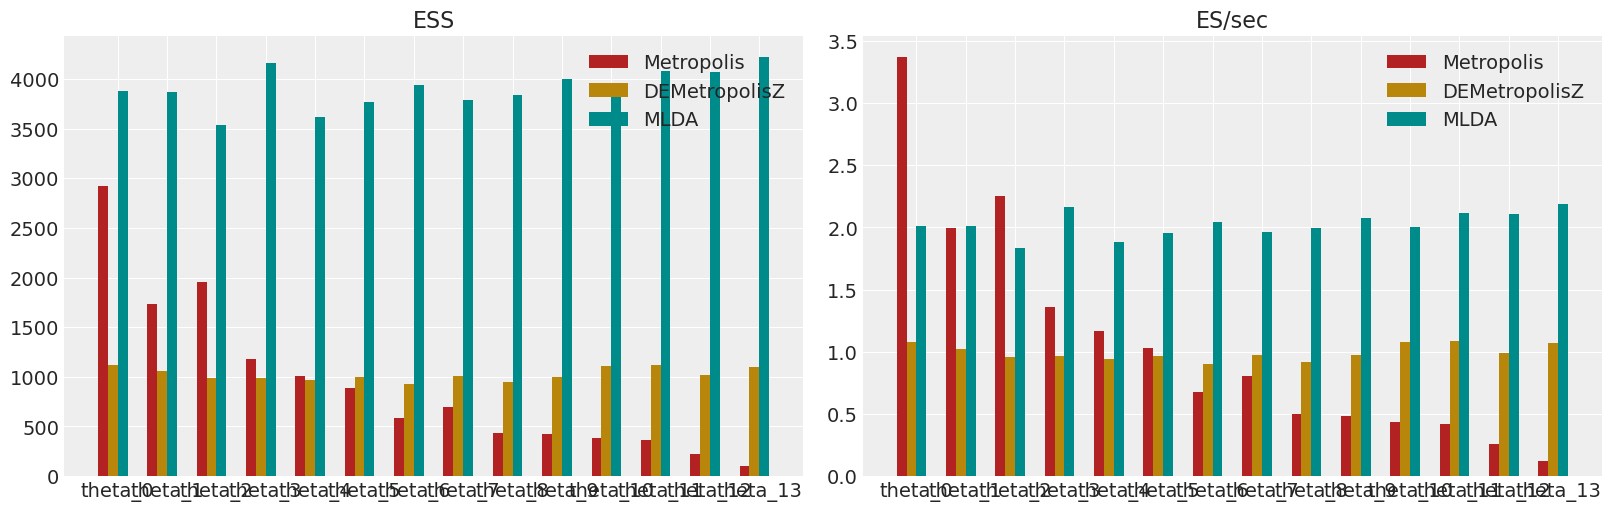

In [28]:
acc = []
ess = []
ess_n = []
performances = []

# Get some more statistics.
with model:
    for i, trace in enumerate(traces):
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
        print(
            f"\n{method_names[i]} Sampler: {len(trace)} drawn samples in each of "
            f"{trace.nchains} chains."
            f"\nRuntime: {runtimes[i]} seconds"
            f"\nAcceptance rate: {acc[i]}"
            f"\nESS list: {np.round(ess[i][0], 3)}"
            f"\nNormalised ESS list: {np.round(ess_n[i][0], 3)}"
            f"\nESS/sec: {np.round(performances[i][0], 3)}"
        )

    # Plot the effective sample size (ESS) and relative ESS (ES/sec) of each of the sampling strategies.
    colors = ["firebrick", "darkgoldenrod", "darkcyan", "olivedrab"]

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].set_title("ESS")
    for i, e in enumerate(ess):
        axes[0].bar(
            [j + i * 0.2 for j in range(mkl)],
            e.ravel(),
            width=0.2,
            color=colors[i],
            label=method_names[i],
        )
    axes[0].set_xticks([i + 0.3 for i in range(mkl)])
    axes[0].set_xticklabels([f"theta_{i}" for i in range(mkl)])
    axes[0].legend()

    axes[1].set_title("ES/sec")
    for i, p in enumerate(performances):
        axes[1].bar(
            [j + i * 0.2 for j in range(mkl)],
            p.ravel(),
            width=0.2,
            color=colors[i],
            label=method_names[i],
        )
    axes[1].set_xticks([i + 0.3 for i in range(mkl)])
    axes[1].set_xticklabels([f"theta_{i}" for i in range(mkl)])
    axes[1].legend()
    plt.show()

#### Plot distributions and trace.
Vertical grey lines represent the MAP estimate of each parameter.

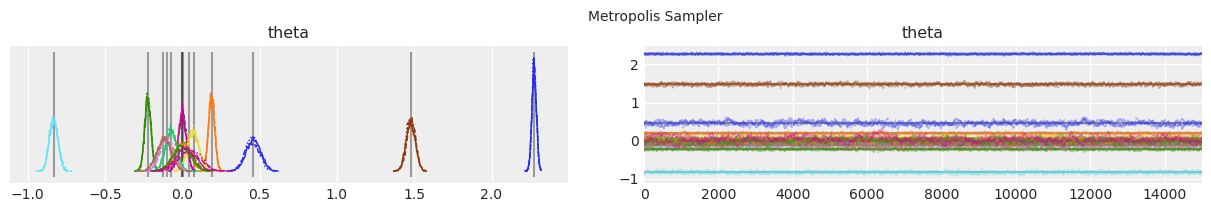

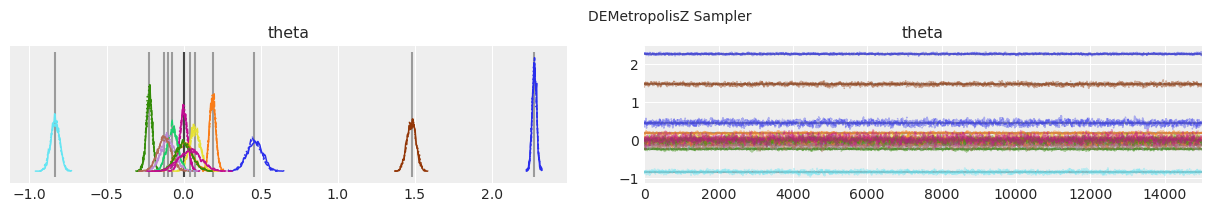

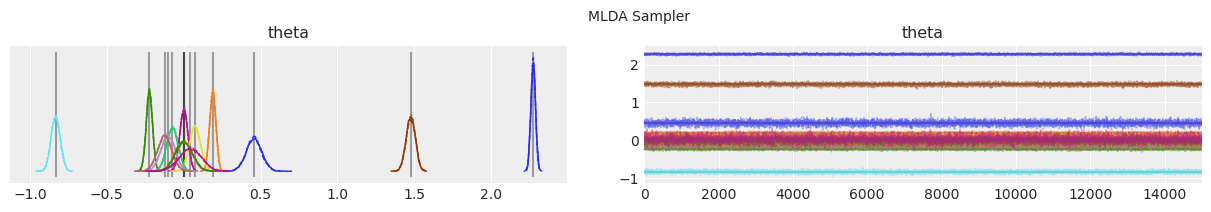

In [29]:
with model:
    lines = (("theta", {}, MAP["theta"].tolist()),)
    for i, trace in enumerate(traces):
        az.plot_trace(trace, lines=lines)

        # Ugly hack to get some titles in.
        x_offset = -0.1 * ndraws
        y_offset = trace.get_values("theta").max() + 0.25 * (
            trace.get_values("theta").max() - trace.get_values("theta").min()
        )
        plt.text(x_offset, y_offset, "{} Sampler".format(method_names[i]))

#### Plot true and recovered densities
This is useful for verification, i.e. to compare the true model density and signal to the estimated ones from the samplers.

True Model


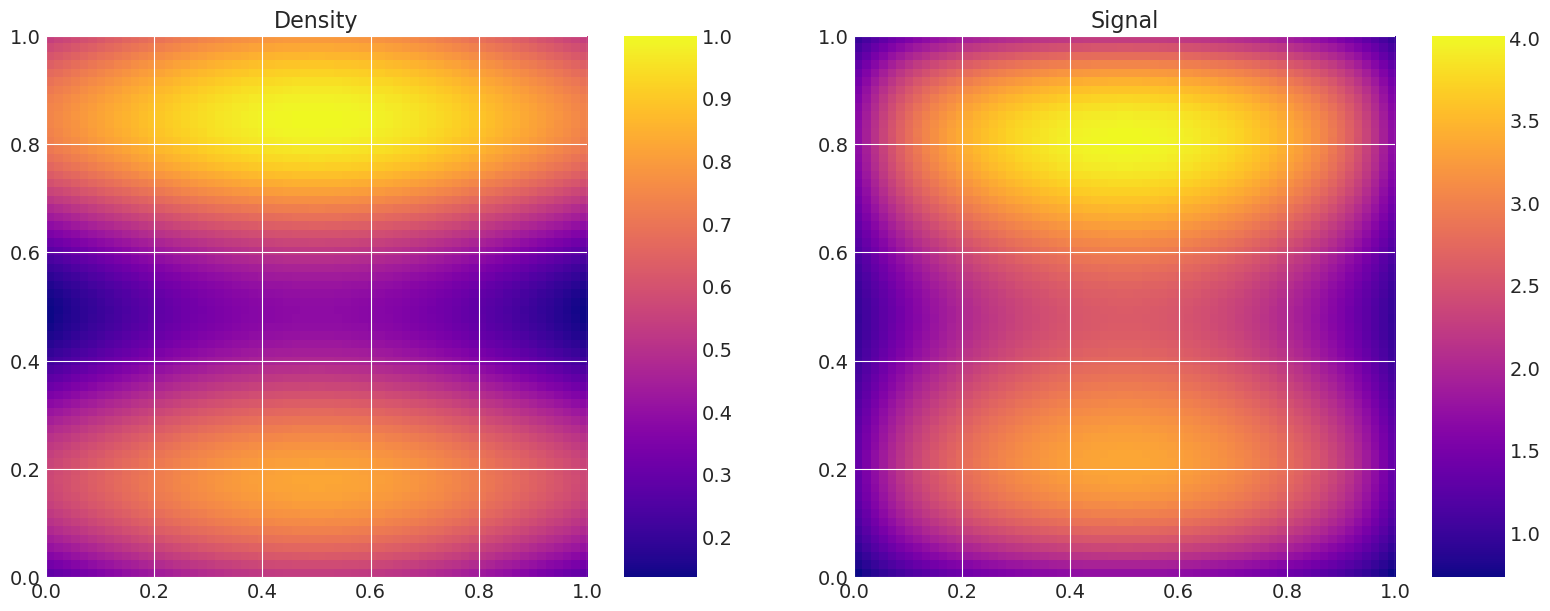

MAP estimate:


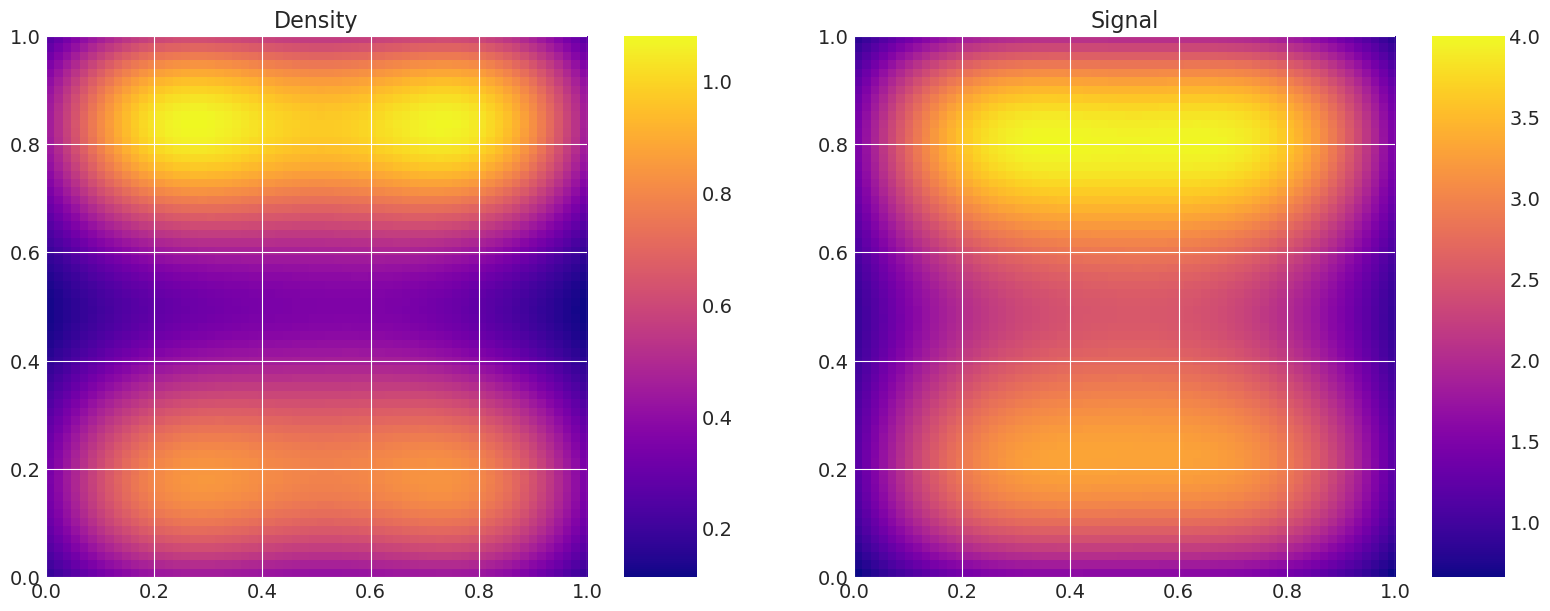

Recovered by: Metropolis


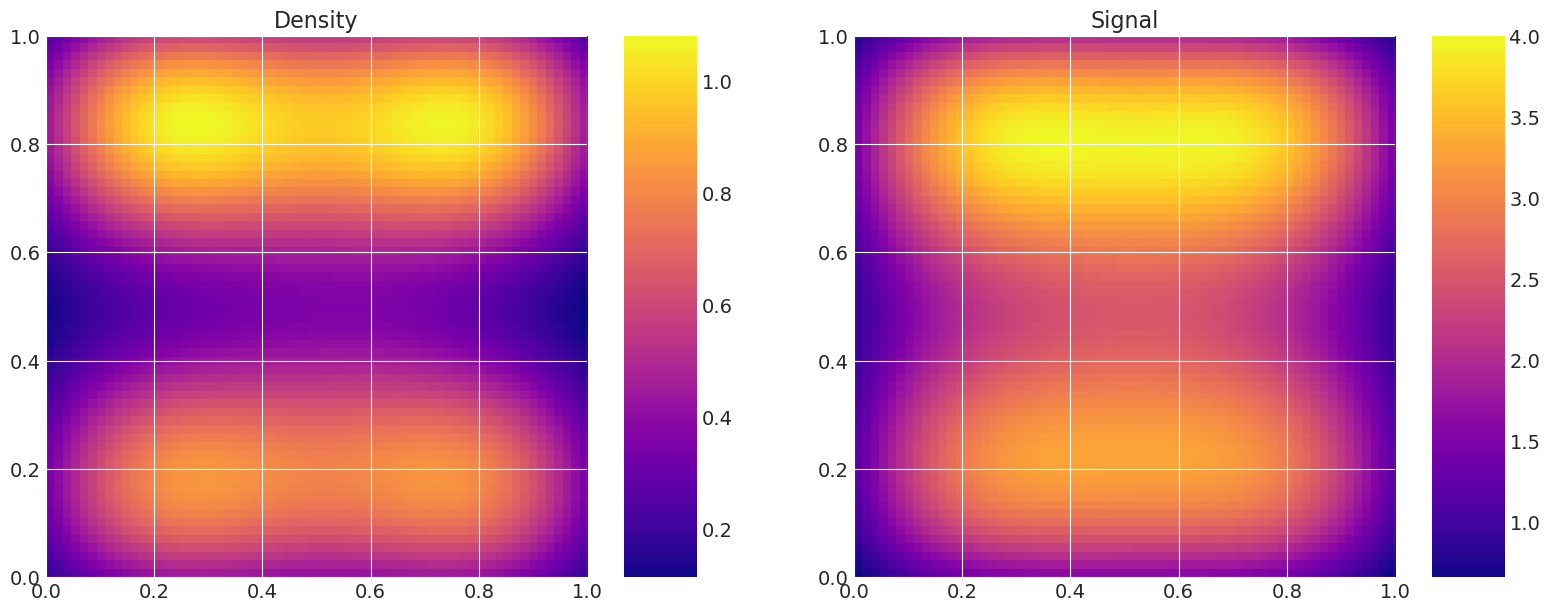

Recovered by: DEMetropolisZ


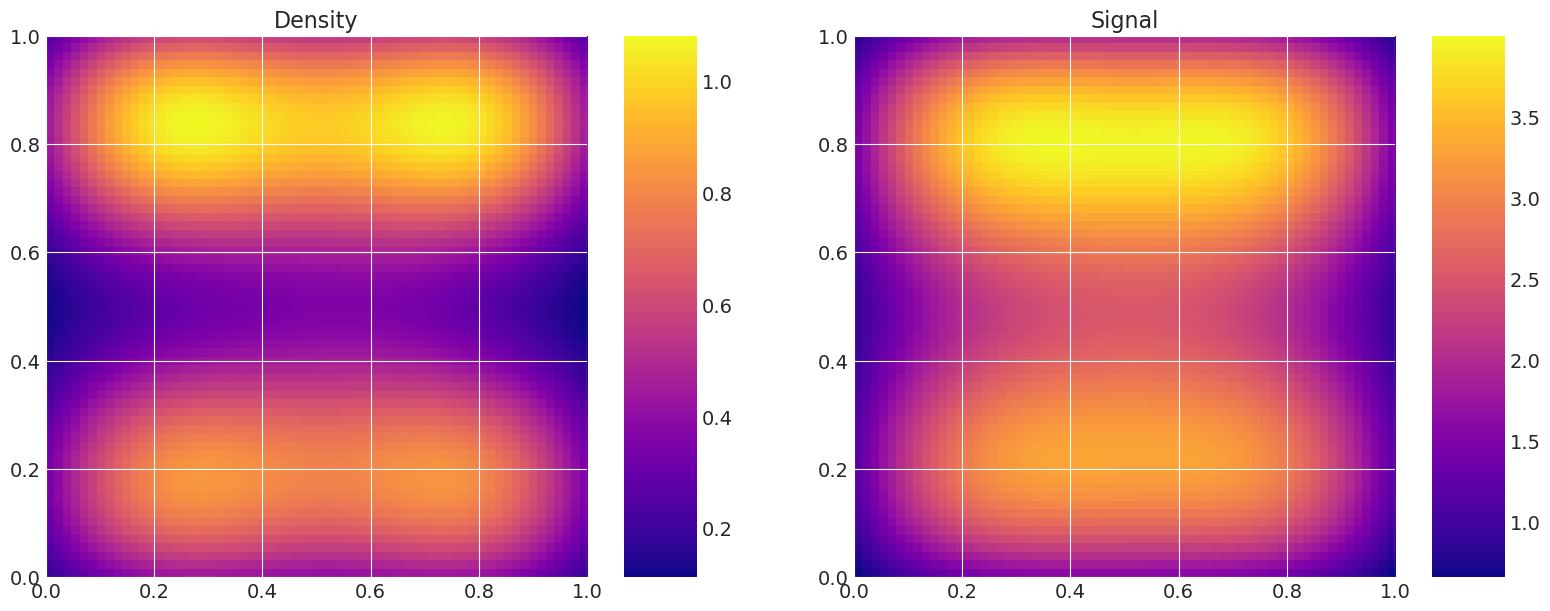

Recovered by: MLDA


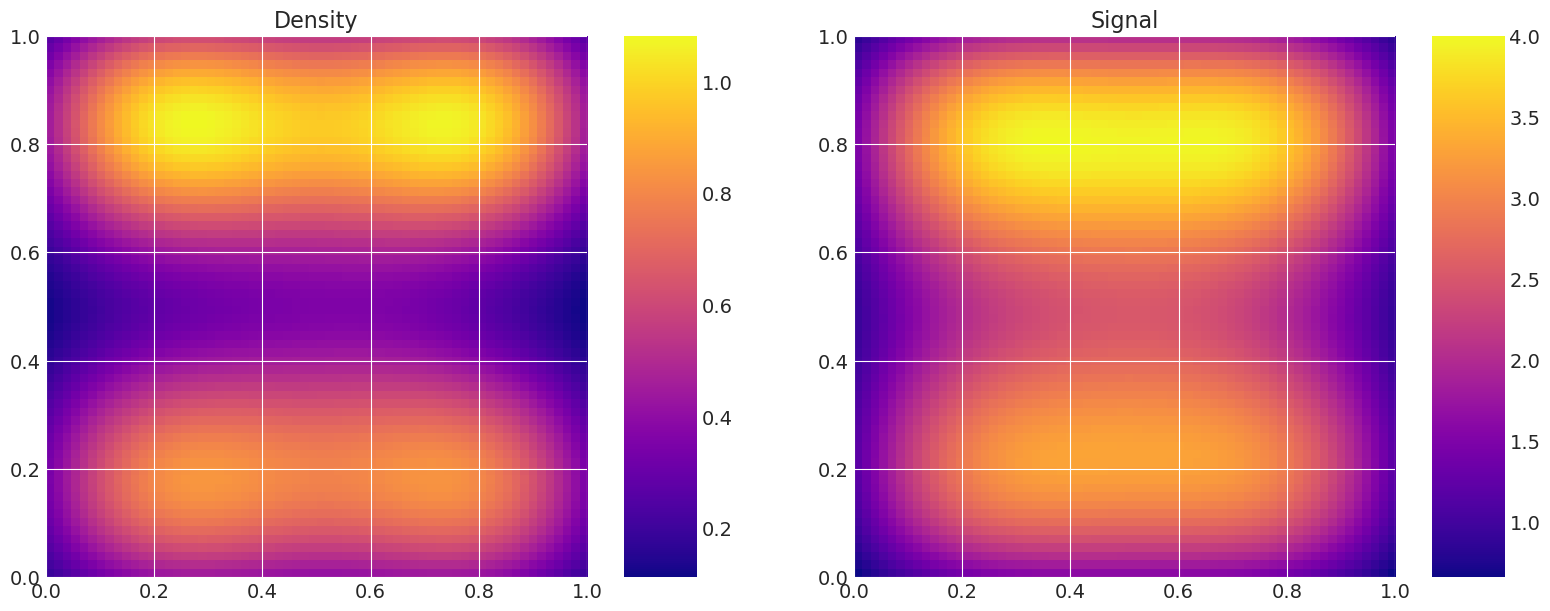

In [30]:
print("True Model")
model_true.plot_model()
with model:
    print("MAP estimate:")
    my_models[-1].solve(MAP["theta"])
    my_models[-1].plot_model()
    for i, t in enumerate(traces):
        print(f"Recovered by: {method_names[i]}")
        my_models[-1].solve(az.summary(t)["mean"].values)
        my_models[-1].plot_model()

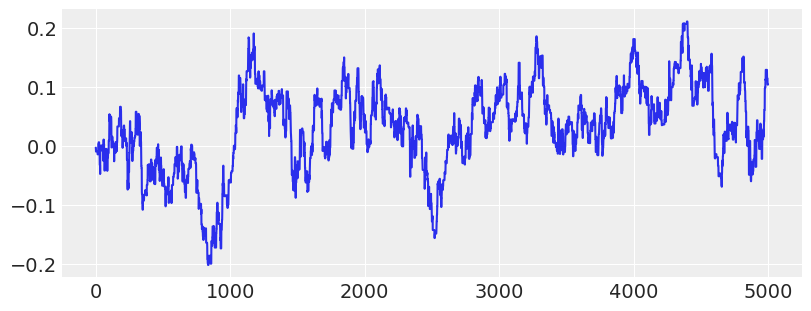

In [31]:
# Show trace of lowest energy mode for Metropolis sampler
plt.figure(figsize=(8, 3))
plt.plot(traces[0]["theta"][:5000, -1])
plt.show()

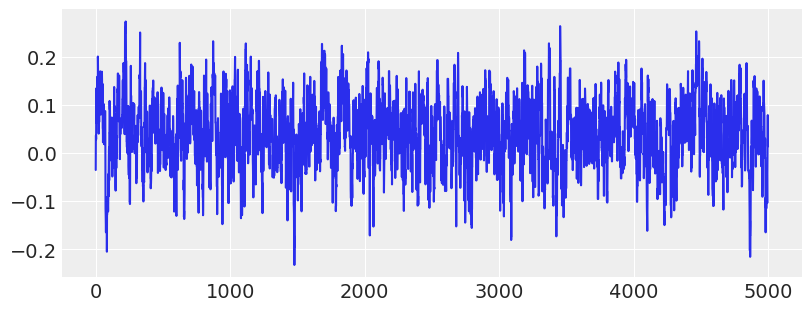

In [32]:
# Show trace of lowest energy mode for MLDA sampler
plt.figure(figsize=(8, 3))
plt.plot(traces[2]["theta"][:5000:, -1])
plt.show()

In [33]:
# Make sure samplers have converged
assert all(az.rhat(traces[0]) < 1.03)
assert all(az.rhat(traces[1]) < 1.03)
assert all(az.rhat(traces[2]) < 1.03)

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Feb 06 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

numpy     : 1.20.0
pandas    : 1.2.1
pymc3     : 3.11.0
sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
theano    : 1.1.2
matplotlib: None
arviz     : 0.11.0

Watermark: 2.1.0

